### 依赖环境
```
numpy
matplotlib
tqdm
scikit-learn
```

In [1]:
# 安装所需环境
!pip install numpy matplotlib tqdm scikit-learn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


#### MNIST数据读取与可视化

In [2]:
import gzip
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
%matplotlib inline

def load_mnist_images(filename, num_images, image_size=28):
    with gzip.open(filename, 'r') as f:
        f.read(16)  # skip header
        buf = f.read(image_size ** 2 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        return data.reshape(num_images, image_size, image_size, 1)

def load_mnist_labels(filename, num_labels):
    with gzip.open(filename, 'r') as f:
        f.read(8)  # skip header
        return np.frombuffer(f.read(num_labels), dtype=np.uint8)

# Load data
tr_img = load_mnist_images(osp.join("dataset", "train-images-idx3-ubyte.gz"), 60000) / 255.0
tr_lbl = load_mnist_labels(osp.join("dataset", "train-labels-idx1-ubyte.gz"), 60000)
te_img = load_mnist_images(osp.join("dataset", "t10k-images-idx3-ubyte.gz"), 10000) / 255.0
te_lbl = load_mnist_labels(osp.join("dataset", "t10k-labels-idx1-ubyte.gz"), 10000)

# Display sizes
print(f"训练集图片形状: {tr_img.shape}")
print(f"训练机标签形状: {tr_lbl.shape}")
print(f"测试集图片形状: {te_img.shape}")
print(f"测试集标签形状: {te_lbl.shape}")

训练集图片形状: (60000, 28, 28, 1)
训练机标签形状: (60000,)
测试集图片形状: (10000, 28, 28, 1)
测试集标签形状: (10000,)


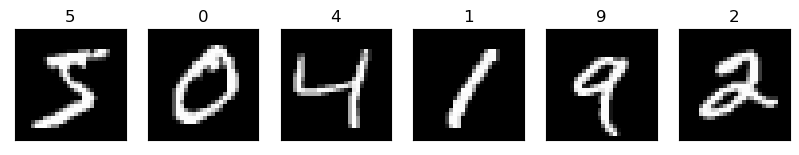

In [3]:
def show_images(images, labels, sample):
    plt.figure(figsize=(10 , 7), dpi=100)

    for i in range(sample):        
        image = images[i]    
        label = labels[i]

        plt.subplot(1, sample, i + 1)        
        plt.imshow(image, cmap=plt.cm.gray)
        plt.title(label)
        plt.xticks([])
        plt.yticks([])
   
show_images(tr_img, tr_lbl, 6)

#### 二分类支持向量机（binary SVM）实现
实现了一个基于序列最小优化（SMO）算法的二分类支持向量机。以下为代码主要部分的解析：

1. **初始化函数 (`__init__`)**：
    - `C`: 松弛变量的惩罚系数，默认为1.0。
    - `KKT_tol`: KKT条件的容忍度，默认为1e-3。
    - `epochs`: SMO算法的最大迭代次数，默认为1e2。
    - `kernel_type`: 核函数类型，默认为线性核（"linear"）。可以选择"linear"或者RBF核函数。
    - `gamma_rbf`: RBF核函数的`gamma`参数，默认为1.0。

2. **模型训练 (`fit`)**：
    - 初始化`alpha`向量，并设置初始的支持向量和对应的标签。
    - 在给定的迭代次数内，选择违反KKT条件的`alpha1`和`alpha2`，并对它们进行更新。

3. **预测函数 (`pred`)**：
    - 输入为特征矩阵`x`。
    - 返回预测的类标签和决策函数的值。

4. **选择乘子alpha1 (`a1_search`)**：
    - 基于KKT条件选择违反该条件的`alpha1`。

5. **选择乘子alpha2 (`a2_search`)**：
    - 根据误差选择`alpha2`。

6. **检查KKT条件 (`kkt_cond`)**：
    - 返回一个布尔值，指示给定的索引是否满足KKT条件。

7. **核函数**：
    - **线性核 (`linear`)**：返回两个输入向量的点积。
    - **RBF核 (`rbf_kernel`)**：根据给定的`gamma`参数和两个输入向量，返回RBF核的值。

该SVM可以用于二分类任务，根据任务的需要选择合适的核函数和参数。

In [4]:
import itertools
from functools import partial

class binarySVM:
    # 初始化函数
    def __init__(
        self,
        C: float = 1.0,                 # 松弛变量惩罚系数
        KKT_tol: float = 1e-3,          # KKT条件的容忍度
        epochs: int = -1,              # 最大迭代次数
        kernel_type: str = "linear",    # 核函数类型
        gamma_rbf: float = 1.0,         # RBF核函数的gamma参数
    ) -> None:
        self.C = C                  
        self.epochs = epochs        
        self.KKT_tol = KKT_tol
        self.kernel = self.linear if kernel_type == "linear" else partial(self.rbf_kernel, gamma=gamma_rbf)
        self.b = 0
        self.a = np.array([])
        self.sv, self.sv_lbl = np.array([]), np.array([])

    # 训练模型
    def fit(self, x, y):
        self.a = np.zeros(x.shape[0])
        self.sv, self.sv_lbl = x, y

        bad_kkt = np.arange(x.shape[0])
        self.kernel_matrix = self.kernel(self.sv, x)

        #  @ self.kernel(self.sv, x) + self.b
        error_lst = (self.sv_lbl * self.a) @ self.kernel_matrix + self.b  - y

        loop = itertools.count() if self.epochs == -1 else range(self.epochs)

        for l in loop:
            if l > 1e4:
                break

            # 选择alpha1和alpha2的索引
            i1, bad_kkt = self.a1_search(bad_kkt)
            if i1 == -1:
                break

            i2 = self.a2_search(i1, error_lst)

            if i1 != i2:
                x1, x2 = self.sv[i1, :], self.sv[i2, :]
                y1, y2 = self.sv_lbl[i1], self.sv_lbl[i2]
                a1, a2 = self.a[i1], self.a[i2]
                k11, k12, k22 = self.kernel_matrix[i1, i1], self.kernel_matrix[i1, i2], self.kernel_matrix[i2, i2]
                
                # 根据alpha1和alpha2来计算L和H
                L = np.max([0, a1 + a2 - self.C]) if y1 == y2 else np.max([0, a2 - a1])
                H = np.min([self.C, a1 + a2]) if y1 == y2 else np.min([self.C, self.C + a2 - a1])
                
                if L != H:
                    # 计算eta用于更新alpha1和alpha2
                    eta = k11 + k22 - 2 * k12

                    if eta:
                        lbl = self.sv_lbl * self.a
                        e1 = lbl @ self.kernel_matrix[i1] + self.b - y1
                        e2 = lbl @ self.kernel_matrix[i2] + self.b - y2

                        a2_new = np.clip(a2 + y2 * (e1 - e2) / eta, L, H)
                        a1_new = a1 + y1 * y2 * (a2 - a2_new)
                        a1_delta, a2_delta = a1_new - self.a[i1], a2_new - self.a[i2]

                        # 计算新的b
                        if 0 < a1_new < self.C:
                            self.b -= e1 - y1 * a1_delta * k11 - y2 * a2_delta * k12
                        elif 0 < a2_new < self.C:
                            self.b -= e2 - y1 * a1_delta * k12 - y2 * a2_delta * k22
                        else:
                            b1 = self.b - e1 - y1 * a1_delta * k11 - y2 * a2_delta * k12
                            b2 = self.b - e2 - y1 * a1_delta * k12 - y2 * a2_delta * k22
                            self.b = (b1 + b2) / 2

                        # 更新alpha1和alpha2以及error_lst
                        self.a[i1], self.a[i2] = a1_new, a2_new
                        lbl = self.sv_lbl * self.a
                        error_lst[i1] = lbl @ self.kernel_matrix[i1] + self.b
                        error_lst[i2] = lbl @ self.kernel_matrix[i2] + self.b

        # 保存支持向量
        self.sv = self.sv[self.a != 0, :]
        self.sv_lbl = self.sv_lbl[self.a != 0]
        self.a = self.a[self.a != 0]

    # 预测函数，返回类标签和决策函数的值
    def pred(self, x: np.ndarray):
        prob = (self.sv_lbl * self.a) @ self.kernel(self.sv, x) + self.b
        return np.sign(prob), prob

    # 根据KKT条件选择乘子alpha1
    def a1_search(self, bad_kkt):
        for i in bad_kkt:
            if not self.kkt_cond(i):
                return i, bad_kkt[bad_kkt != i]

        bad_kkt = np.arange(self.a.shape[0])[~self.kkt_cond(np.arange(self.a.shape[0]))]
        if bad_kkt.size:
            bad_kkt = np.random.permutation(bad_kkt)
            return bad_kkt[0], bad_kkt[1:]
        return -1, np.array([])

    # 根据error选择乘子alpha2
    def a2_search(self, i, error):
        index = np.array([i for i, a in enumerate(self.a) if 0 < a < self.C])
        if index.size:
            func = np.argmin if error[i] >= 0 else np.argmax
            return index[func(error[index])]
        else:
            return np.argmax(np.abs(error - error[i]))

    # 检查KKT条件是否满足
    def kkt_cond(self, i):
        prob = (self.sv_lbl * self.a) @ self.kernel_matrix[i] + self.b
        cond_1 = (self.a[i] < self.C) & (self.sv_lbl[i] * prob < 1 - self.KKT_tol)
        cond_2 = (self.a[i] > 0) & (self.sv_lbl[i] * prob > 1 + self.KKT_tol)
        return ~(cond_1 | cond_2)

    # 线性核函数实现
    @staticmethod
    def linear(x1, x2):
        return x1 @ x2.T

    @staticmethod
    def rbf_kernel(x1, x2, gamma):
        x1 = x1[np.newaxis, :] if np.ndim(x1) == 1 else x1
        x2 = x2[np.newaxis, :] if np.ndim(x2) == 1 else x2

        dist_squared = np.sum(x1 ** 2, axis=1)[:, np.newaxis] \
                      + np.sum(x2 ** 2, axis=1)[np.newaxis, :] \
                      - 2 * (x1 @ x2.T)

        return np.exp(-gamma * np.squeeze(dist_squared))



#### 多类支持向量机（multiclass SVM）实现
基于一对一策略（One-vs-One, OvO）的多类支持向量机实现。对于每两个类别，它都会训练一个二分类SVM。在预测时，每个二分类SVM对输入数据进行预测并进行投票。最终，获得最多票数的类别被选为该输入数据的预测类别。以下为代码主要部分的解析：

1. **初始化函数 (`__init__`)**：
    - `num_cls`: 类别的数量。
    - 使用OvO策略，为每一对类别初始化一个二分类支持向量机实例。

2. **模型训练 (`fit`)**：
    - 遍历每一对类别。
    - 使用逻辑或运算选取与当前类别对应的数据点。
    - 根据筛选出的数据训练对应的binary SVM。

3. **预测函数 (`pred`)**：
    - 初始化一个零矩阵，用于存储每个类别的投票数。
    - 遍历每一对类别，为每个数据点投票。
    - 根据投票数，为每个数据点选取获得最多投票的类别作为预测结果。

In [5]:
from tqdm import tqdm

class multiclassSVM:
    def __init__(self, num_cls, display=False, strategy="ovo", **kws):
        self.binarySVM = []
        self.pairs = []
        self.num_cls = num_cls
        self.display = display
        self.strategy = strategy
        if self.strategy == "ovo":
            for i in range(self.num_cls):
                for j in range(i + 1, self.num_cls):
                    self.binarySVM.append(binarySVM(**kws))
                    self.pairs.append((i, j))
        elif self.strategy == "ova":
            for i in range(self.num_cls):
                self.binarySVM.append(binarySVM(**kws))

    def fit(self, x, y):
        if self.strategy == "ovo":
            pairs = self.pairs
            if self.display:
                print("训练多分类SVM...")
                pairs = tqdm(self.pairs)
            for idx, (cls_a, cls_b) in enumerate(pairs):
                mask = np.logical_or(y == cls_a, y == cls_b)
                x_filtered = x[mask]
                y_filtered = np.where(y[mask] == cls_a, 1., -1.)
                self.binarySVM[idx].fit(x_filtered, y_filtered)
        elif self.strategy == "ova":
            if self.display:
                print("训练多分类SVM...")
                self.binarySVM = tqdm(self.binarySVM)
            for idx, svm in enumerate(self.binarySVM):
                mask = np.where(y == idx, 1., -1.)
                svm.fit(x, mask)

    def pred(self, x):
        if self.strategy == "ovo":
            pairs = self.pairs
            if self.display:
                print("预测...")
                pairs = tqdm(self.pairs)
            votes = np.zeros((x.shape[0], self.num_cls))
            for idx, (cls_a, cls_b) in enumerate(pairs):
                predictions = self.binarySVM[idx].pred(x)[0]
                for i, pred in enumerate(predictions):
                    if pred == 1.:
                        votes[i, cls_a] += 1
                    else:
                        votes[i, cls_b] += 1
        elif self.strategy == "ova":
            if self.display:
                print("预测...")
                self.binarySVM = tqdm(self.binarySVM)
            votes = np.zeros((x.shape[0], self.num_cls))
            for idx, svm in enumerate(self.binarySVM):
                votes[:, idx] = svm.pred(x)[1]
        return np.argmax(votes, axis=1)

#### 训练多分类SVM
我用`multiclassSVM`这个类来训练了MNIST数据集的训练集，由于本地计算资源的限制，只选取了训练集中的前$1000$张图片。
超参数总结如下：
| 超参数 | 数值 | 含义 |
|   -   |  -  |  -  |
|  $C$  | 10 | 松弛变量惩罚系数 |
| KKT_tol | 0.1 | KKT条件的容忍度 |
| epochs | 1000 | 最大epoch的数目，-1代表训练直到收敛 |
| kernel_type | linear | 核函数类型 |

In [6]:
classifier = multiclassSVM(10, display=True, C=10, KKT_tol=0.1, epochs=1000, kernel_type="linear")
classifier.fit(tr_img.reshape((-1, 28**2))[:2000], tr_lbl[:2000])

y_pred = classifier.pred(te_img.reshape((-1, 28**2)))
acc = np.mean(y_pred==te_lbl.astype(np.uint8))
print(f"多分类SVM的推理准确率为: {acc:.2%}")

训练多分类SVM...


  0%|          | 0/45 [00:00<?, ?it/s]

100%|██████████| 45/45 [00:06<00:00,  7.17it/s]


预测...


100%|██████████| 45/45 [00:01<00:00, 44.40it/s]

多分类SVM的推理准确率为: 84.53%


#### 基于sklearn库的多分类SVM
我用sklearn实现了一个多分类svm；为了与上面比较公平，我也采用了训练集前$1000$张图片作为训练数据，$C$设定为0.05，策略为ovo

In [7]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(kernel='linear', C=10, max_iter=1000, decision_function_shape='ovo')
clf.fit(tr_img.reshape((-1, 28**2))[:2000], tr_lbl[:2000])

y_pred = clf.predict(te_img.reshape((-1, 28**2)))

accuracy = accuracy_score(te_lbl, y_pred)
print(f"基于sklearn多分类SVM的推理准确率为: {accuracy * 100:.2f}%")

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


基于sklearn多分类SVM的推理准确率为: 89.16%


#### 参数搜索

In [8]:
from sklearn.model_selection import KFold

def grid_search_hyperparams(x, y, C_values, KKT_tol_values, n_folds=5):
    best_score = -np.inf
    best_params = None

    kf = KFold(n_splits=n_folds)

    for C in tqdm(C_values):
        for KKT_tol in KKT_tol_values:
            total_score = 0
            for train_index, test_index in kf.split(x):
                x_train, x_test = x[train_index], x[test_index]
                y_train, y_test = y[train_index], y[test_index]

                model = multiclassSVM(10, C=C, KKT_tol=KKT_tol, epochs=-1)
                model.fit(x_train, y_train)

                predictions = model.pred(x_test)
                accuracy = np.mean(predictions == y_test)

                total_score += accuracy

            avg_score = total_score / n_folds

            if avg_score > best_score:
                best_score = avg_score
                best_params = {"C": C, "KKT_tol": KKT_tol}

    return best_params["C"], best_params["KKT_tol"]

C, KKT_tol = grid_search_hyperparams(tr_img.reshape((-1, 28**2))[:2000], tr_lbl[:2000], [0.01, 10, 100], [1e-2, 1e-1, 5e-1])

100%|██████████| 3/3 [05:42<00:00, 114.07s/it]


In [9]:
# 基于最优参数的线性预测结果
print(f"C={C}, KKT_tol={KKT_tol}")
classifier = multiclassSVM(10, display=True, C=C, KKT_tol=KKT_tol, epochs=-1, kernel_type="linear")
classifier.fit(tr_img.reshape((-1, 28**2))[:2000], tr_lbl[:2000])

y_pred = classifier.pred(te_img.reshape((-1, 28**2)))
acc = np.mean(y_pred==te_lbl.astype(np.uint8))
print(f"多分类SVM的推理准确率为: {acc:.2%}")

C=0.01, KKT_tol=0.01
训练多分类SVM...


  0%|          | 0/45 [00:00<?, ?it/s]

100%|██████████| 45/45 [00:11<00:00,  3.93it/s]


预测...


100%|██████████| 45/45 [00:00<00:00, 57.93it/s]

多分类SVM的推理准确率为: 89.59%


#### RBF kernel实现

In [10]:
classifier = multiclassSVM(10, display=True, C=10, KKT_tol=1e-2, epochs=-1, kernel_type="rbf", gamma_rbf=0.01)
classifier.fit(tr_img.reshape((-1, 28**2))[:2000], tr_lbl[:2000])

y_pred = classifier.pred(te_img.reshape((-1, 28**2)))
acc = np.mean(y_pred==te_lbl.astype(np.uint8))
print(f"多分类SVM(RBF核)的推理准确率为: {acc:.2%}")

训练多分类SVM...


  0%|          | 0/45 [00:00<?, ?it/s]

100%|██████████| 45/45 [00:17<00:00,  2.59it/s]


预测...


100%|██████████| 45/45 [00:01<00:00, 26.03it/s]

多分类SVM(RBF核)的推理准确率为: 93.10%


#### sklearn的RBF kernel实现

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(kernel='rbf', C=10, max_iter=-1, decision_function_shape='ovo')
clf.fit(tr_img.reshape((-1, 28**2))[:2000], tr_lbl[:2000])

y_pred = clf.predict(te_img.reshape((-1, 28**2)))

accuracy = accuracy_score(te_lbl, y_pred)
print(f"基于sklearn多分类SVM的推理准确率为: {accuracy * 100:.2f}%")

基于sklearn多分类SVM的推理准确率为: 93.44%


#### 分析不同kernel的区别


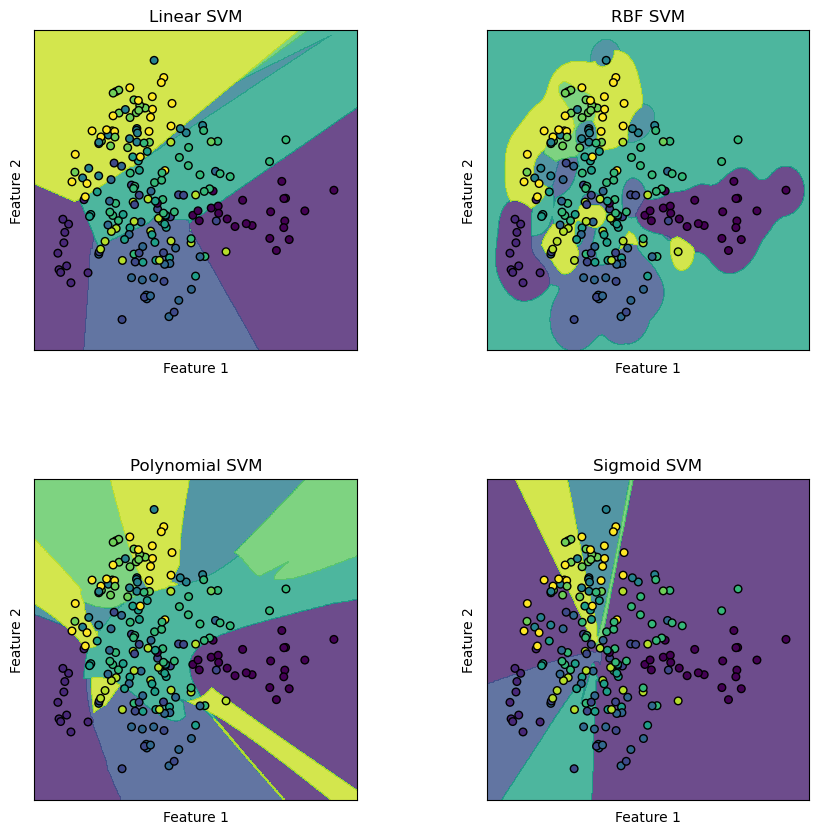

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X_pca = pca.fit_transform(tr_img.reshape(-1, 28**2))
indices = np.random.choice(len(X_pca), 200, replace=False)
X_sample = X_pca[indices]
y_sample = tr_lbl[indices]

def plot_svm_kernels(X, y):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    titles = ['Linear SVM', 'RBF SVM', 'Polynomial SVM', 'Sigmoid SVM']

    plt.figure(figsize=(10, 10))

    for i, kernel in enumerate(('linear', 'rbf', 'poly', 'sigmoid')):
        clf = SVC(kernel = kernel, gamma = 2)
        clf.fit(X, y)
        plt.subplot(2, 2, i + 1)
        plt.subplots_adjust(wspace = 0.4, hspace = 0.4)

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.8)

        plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=30)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        plt.title(titles[i])

    plt.show()

plot_svm_kernels(X_sample, y_sample)